In [1]:
import pandas as pd
import numpy as np
import os, sys
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve
sys.path.append(os.path.abspath('../GCN'))

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn
import gcnIO, postprocessing

%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
gridsearch_dir = '/project/gcn/deepwalk/deepwalk_gridsearch/'
data_file = '/project/gcn/diseasegcn/data/pancancer/CPDB_multiomics_omimallneg.h5'

def get_model_performance(embedding_file, features, node_names, y_train, train_mask, y_test, test_mask, out_file=None):
    deepwalk_embeddings = pd.read_csv(embedding_file, header=None, skiprows=1, sep=' ')
    deepwalk_embeddings.columns = ['Node_Id'] + deepwalk_embeddings.columns[1:].tolist()
    deepwalk_embeddings.set_index('Node_Id', inplace=True)
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    embedding_with_names = deepwalk_embeddings.join(nodes)

    X_dw = embedding_with_names.set_index('Name').reindex(nodes.Name).drop('ID', axis=1)
    X_train_dw = X_dw[train_mask.astype(np.bool)]
    X_test_dw = X_dw[test_mask.astype(np.bool)]
    y_train_dw = y_train[train_mask.astype(np.bool)]
    y_test_dw = y_test[test_mask.astype(np.bool)]

    clf = SVC(kernel='rbf', class_weight='balanced', probability=True)
    #clf = RandomForestClassifier()
    #clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train_dw, y_train_dw.reshape(-1))
    pred_deepwalk = clf.predict_proba(X_test_dw)
    print (pred_deepwalk.shape)
    pr_dw, rec_dw, thresholds_dw = precision_recall_curve(y_true=y_test_dw,
                                                          probas_pred=pred_deepwalk[:, 1])
    aupr_dw = average_precision_score(y_true=y_test_dw, y_score=pred_deepwalk[:, 1])
    if not out_file is None:
        fig = plt.figure(figsize=(14, 8))
        plt.plot(rec_dw, pr_dw, lw=6, label='DeepWalk (AUPR = {0:.2f})'.format(aupr_dw))
        plt.legend()
        print (os.path.dirname(embedding_file))
        fig.savefig(os.path.join(os.path.dirname(embedding_file), out_file))
    return aupr_dw


data = gcnIO.load_hdf_data(path=data_file)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data

performances = []
for param_file in os.listdir(gridsearch_dir):
    if param_file.startswith('embedding_') and os.path.isfile(os.path.join(gridsearch_dir, param_file)):
        perf = get_model_performance(embedding_file=os.path.join(gridsearch_dir, param_file),
                                     features=features,
                                     node_names=node_names,
                                     y_train=y_train,
                                     train_mask=train_mask,
                                     y_test=y_val,
                                     test_mask=val_mask,
                                     out_file=None
                                     #out_file='pr_curve_{}.svg'.format(param_file.split('_')[1])
                                    )
        print ("{0} -> AUPR: {1:.2f}".format(param_file, perf))
        performances.append(perf)

(156, 2)
embedding_0 -> AUPR: 0.76
(156, 2)
embedding_1 -> AUPR: 0.84
(156, 2)
embedding_2 -> AUPR: 0.82
(156, 2)
embedding_3 -> AUPR: 0.77
(156, 2)
embedding_4 -> AUPR: 0.79
(156, 2)
embedding_5 -> AUPR: 0.86
(156, 2)
embedding_6 -> AUPR: 0.75
(156, 2)
embedding_7 -> AUPR: 0.80
(156, 2)
embedding_8 -> AUPR: 0.85
(156, 2)
embedding_9 -> AUPR: 0.78
(156, 2)
embedding_10 -> AUPR: 0.79
(156, 2)
embedding_11 -> AUPR: 0.82
(156, 2)
embedding_12 -> AUPR: 0.77
(156, 2)
embedding_13 -> AUPR: 0.79
(156, 2)
embedding_14 -> AUPR: 0.83
(156, 2)
embedding_15 -> AUPR: 0.82
(156, 2)
embedding_16 -> AUPR: 0.82
(156, 2)
embedding_17 -> AUPR: 0.81
(156, 2)
embedding_18 -> AUPR: 0.79
(156, 2)
embedding_19 -> AUPR: 0.78
(156, 2)
embedding_20 -> AUPR: 0.77
(156, 2)
embedding_21 -> AUPR: 0.79
(156, 2)
embedding_22 -> AUPR: 0.78
(156, 2)
embedding_23 -> AUPR: 0.78
(156, 2)
embedding_24 -> AUPR: 0.83
(156, 2)
embedding_25 -> AUPR: 0.81
(156, 2)
embedding_26 -> AUPR: 0.80


(0.6, 0.85)

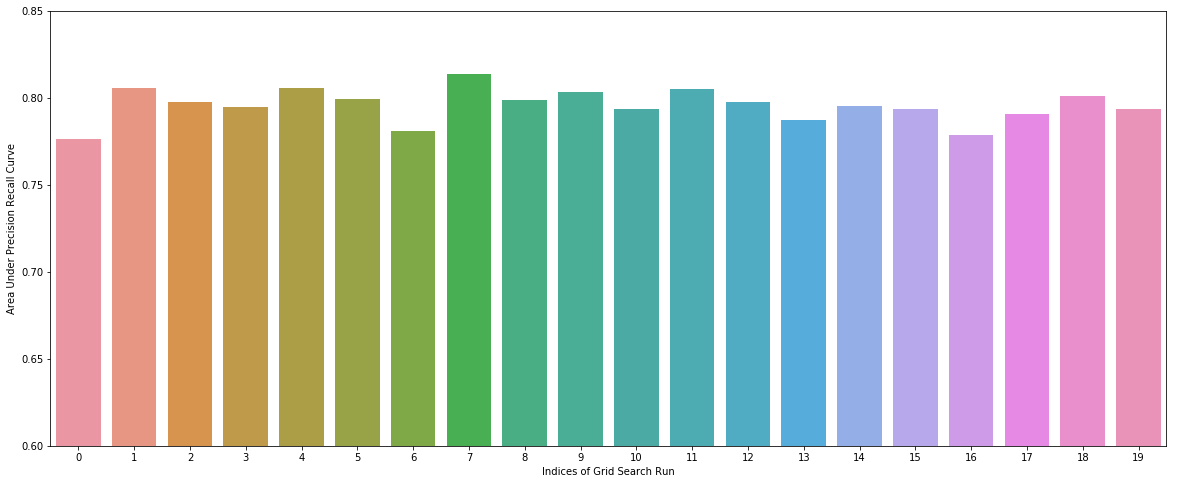

In [29]:
num_to_print = 45
aupr_sorted = sorted(performances, reverse=True)
indices = np.argsort(performances)[::-1]

fig, ax = plt.subplots(figsize=(20, 8))
x = sns.barplot(x=indices, y=aupr_sorted)
#x.set_xticklabels(indices)
ax.set_ylabel('Area Under Precision Recall Curve')
ax.set_xlabel('Indices of Grid Search Run')
ax.set_ylim([0.6, 0.85])
#fig.savefig(os.path.join(training_dir, 'boxplot_best_{}_aupr.png'.format(num_to_print)), dpi=300)

## Overlap with Candidate Cancer Genes

In [17]:
deepwalk_embeddings = pd.read_csv(os.path.join(gridsearch_dir, 'embedding_5'), header=None, skiprows=1, sep=' ')
deepwalk_embeddings.columns = ['Node_Id'] + deepwalk_embeddings.columns[1:].tolist()
deepwalk_embeddings.set_index('Node_Id', inplace=True)
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
embedding_with_names = deepwalk_embeddings.join(nodes)

X_dw = embedding_with_names.set_index('Name').reindex(nodes.Name).drop('ID', axis=1)
X_train_dw = X_dw[train_mask.astype(np.bool)]
X_test_dw = X_dw[test_mask.astype(np.bool)]
y_train_dw = y_train[train_mask.astype(np.bool)]
y_test_dw = y_test[test_mask.astype(np.bool)]

clf = SVC(kernel='rbf', class_weight='balanced', probability=True)
#clf = RandomForestClassifier()
#clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train_dw, y_train_dw.reshape(-1))
pred_deepwalk = clf.predict_proba(X_test_dw)

pr, rec, thresholds = precision_recall_curve(y_true=y_test_dw,
                                                      probas_pred=pred_deepwalk[:, 1])
distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
idx = np.argmin(distances)
best_threshold_pr = thresholds[idx]

pred_all = clf.predict_proba(X_dw)
nodes['Prob_Pos'] = pred_all[:, 1]

In [9]:
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name
known_cancer_genes_innet.shape, len(known_cancer_genes)

((654,), 711)

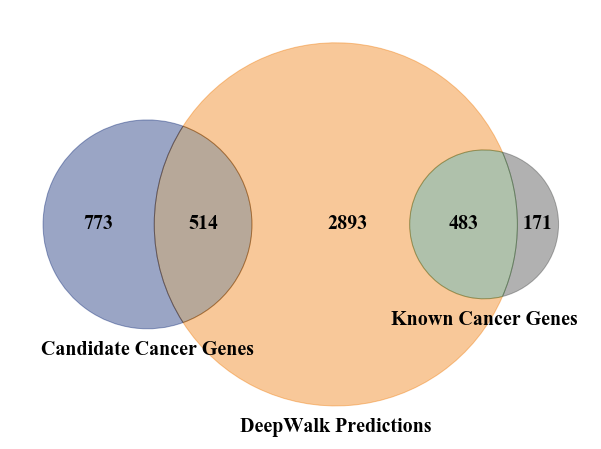

In [19]:
fig = plt.figure(figsize=(14, 8))
v = matplotlib_venn.venn3([set(known_cancer_genes_innet),
                        set(nodes[nodes.Prob_Pos >= best_threshold_pr].Name),
                        set(candidate_cancer_genes_innet)],
        set_labels=['Known Cancer Genes', 'DeepWalk Predictions', 'Candidate Cancer Genes'])
v.get_patch_by_id('10').set_color('#3d3e3d')
if not v.get_patch_by_id('11') is None:
    v.get_patch_by_id('11').set_color('#37652d')
    v.get_label_by_id('11').set_fontsize(20)
v.get_patch_by_id('01').set_color('#ee7600')
v.get_patch_by_id('011').set_color('#4d2600')
v.get_patch_by_id('001').set_color('#031F6F')
v.get_label_by_id('A').set_fontsize(20)
v.get_label_by_id('B').set_fontsize(20)
v.get_label_by_id('C').set_fontsize(20)
v.get_label_by_id('10').set_fontsize(20)
v.get_label_by_id('01').set_fontsize(20)
if not v.get_patch_by_id('111') is None and not v.get_patch_by_id('101') is None:
    v.get_label_by_id('111').set_fontsize(20)
    v.get_label_by_id('101').set_fontsize(20)
    v.get_patch_by_id('111').set_color('#890707')
    v.get_patch_by_id('101').set_color('#6E80B7')
v.get_label_by_id('011').set_fontsize(20)
v.get_label_by_id('001').set_fontsize(20)

In [22]:
nodes['degree'] = network.sum(axis=0)
nodes.head()

,ID,Name,Prob_Pos,degree
0,ENSG00000167323,STIM1,0.191,40.000
1,ENSG00000144935,TRPC1,0.303,17.000
2,ENSG00000089250,NOS1,0.512,39.000
3,ENSG00000058668,ATP2B4,0.179,42.000
4,ENSG00000069431,ABCC9,0.021,3.000


In [23]:
nodes[nodes.Name.isin(candidate_cancer_genes_innet)].degree.median()

20.0

In [24]:
nodes[nodes.Name.isin(known_cancer_genes_innet)].degree.median()

53.0